Tracking performance (CLD vs ARC)


In [1]:
# %%
import sys
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use("CMS")
sys.path.append("/eos/user/v/vriecher/mlpf/notebooks/00_my_notebooks/")
sys.path.append("/eos/user/v/vriecher/mlpf/data_generation/")
from perf import (
    compute_tracking_efficiency_binned,
    compute_track_resolution_p_theta,
    compute_event_energy_binned,
    compute_particle_energy_binned,
    collect_particle_ratio,
)
PLOT_DIR = "/eos/user/v/vriecher/mlpf_plots/tracking_performance/"
from preprocessing.utils_data_creation import particle_feature_order, track_feature_order, hit_feature_order

from plotting import  plot_compare_with_ratio, plot_multicurve_with_ratio, plot_step_hist_compare


In [2]:
IDX = {
    "GEN_PDG": particle_feature_order.index("PDG"),
    "GEN_STATUS": particle_feature_order.index("generatorStatus"),
    "GEN_CHARGE": particle_feature_order.index("charge"),
    "GEN_PT": particle_feature_order.index("pt"),
    "GEN_ETA": particle_feature_order.index("eta"),
    "GEN_E": particle_feature_order.index("energy"),
    "GEN_P": particle_feature_order.index("p"),
    "GEN_VX": particle_feature_order.index("vertex.x"),
    "GEN_VY": particle_feature_order.index("vertex.y"),
    "GEN_VZ": particle_feature_order.index("vertex.z"),

    "TRK_PT": track_feature_order.index("pt"),
    "TRK_ETA": track_feature_order.index("eta"),
    "TRK_D0": track_feature_order.index("D0"),

    "HIT_E": hit_feature_order.index("energy"),
    "HIT_SUBDET": hit_feature_order.index("subdetector"),
}



In [3]:
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

# %%
N_FILES = 1000

# Tracking binning
PT_BINS = np.logspace(-1, 2, 10)             # 0.1 ... 100
THETA_BINS = np.linspace(10, 170, 16)        # degrees
THETA_REGIONS = np.array([[10, 30], [30, 60], [60, 120], [120, 170]])

# Tracking selections
PT_MIN = 1.0
PRIMARY_R_MAX = 50.0
PRIMARY_Z_MAX = 50.0
PDG_PI = [-211]   # pi-

# Calo selections
SUBDETS_ECAL_HCAL = [1, 2]  # check if this matches your encoding

In [4]:
# %%
eff_cld = compute_tracking_efficiency_binned(
    CLD_DIR, n_files=N_FILES, idx=IDX,
    pt_bins=PT_BINS,
    theta_bins=THETA_BINS,
    theta_regions=THETA_REGIONS,
    pt_min=PT_MIN,
    primary_r_max=PRIMARY_R_MAX,
    primary_z_max=PRIMARY_Z_MAX,
    pdg_filter=PDG_PI,
)

eff_arc = compute_tracking_efficiency_binned(
    ARC_DIR, n_files=N_FILES, idx=IDX,
    pt_bins=PT_BINS,
    theta_bins=THETA_BINS,
    theta_regions=THETA_REGIONS,
    pt_min=PT_MIN,
    primary_r_max=PRIMARY_R_MAX,
    primary_z_max=PRIMARY_Z_MAX,
    pdg_filter=PDG_PI,
)

print("Global eff CLD:", eff_cld["eff_global"], "+/-", eff_cld["eff_global_err"])
print("Global eff ARC:", eff_arc["eff_global"], "+/-", eff_arc["eff_global_err"])


Global eff CLD: 0.9970683672813725 +/- 0.00015322357705405365
Global eff ARC: 0.9892301876472906 +/- 0.0002927295252672278


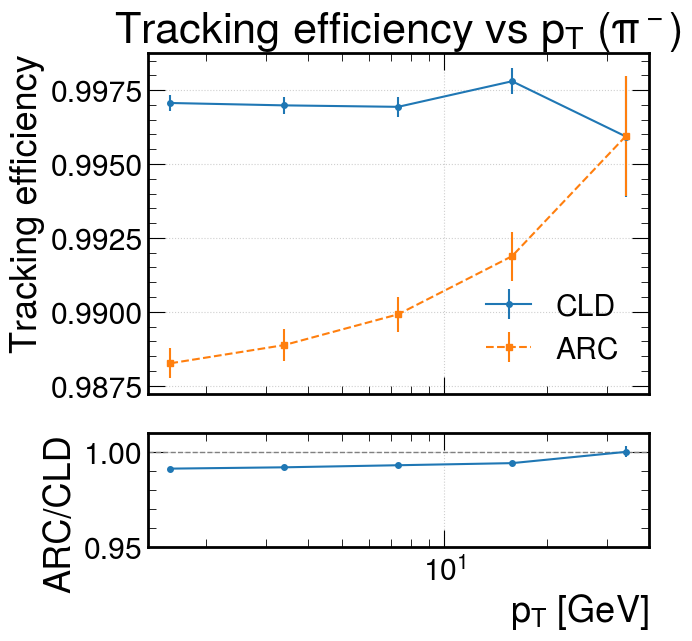

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': 'Tracking efficiency vs $p_T$ ($\\pi^-$)'}, ylabel='Tracking efficiency'>,
  <Axes: xlabel='$p_T$ [GeV]', ylabel='ARC/CLD'>))

In [5]:
# %%
pt_centers = 0.5 * (eff_cld["pt_bins"][:-1] + eff_cld["pt_bins"][1:])

plot_compare_with_ratio(
    pt_centers,
    eff_cld["pt_eff"], eff_arc["pt_eff"],
    eff_cld["pt_err"], eff_arc["pt_err"],
    labelA="CLD", labelB="ARC",
    xlabel=r"$p_T$ [GeV]",
    ylabel="Tracking efficiency",
    title=r"Tracking efficiency vs $p_T$ ($\pi^-$)",
    xscale="log",
    ratio_ylim=(0.95, 1.01),
    # savepath=f"{PLOT_DIR}/trk_eff_vs_pt.png",
)


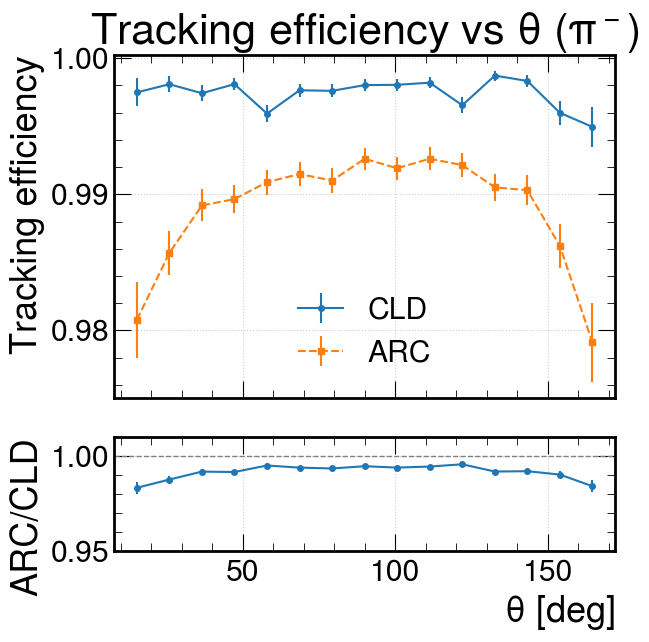

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': 'Tracking efficiency vs $\\theta$ ($\\pi^-$)'}, ylabel='Tracking efficiency'>,
  <Axes: xlabel='$\\theta$ [deg]', ylabel='ARC/CLD'>))

In [6]:
# %%
th_centers = 0.5 * (eff_cld["theta_bins"][:-1] + eff_cld["theta_bins"][1:])

plot_compare_with_ratio(
    th_centers,
    eff_cld["theta_eff"], eff_arc["theta_eff"],
    eff_cld["theta_err"], eff_arc["theta_err"],
    labelA="CLD", labelB="ARC",
    xlabel=r"$\theta$ [deg]",
    ylabel="Tracking efficiency",
    title=r"Tracking efficiency vs $\theta$ ($\pi^-$)",
    ratio_ylim=(0.95, 1.01),
    # savepath=f"{PLOT_DIR}/trk_eff_vs_theta.png",
)


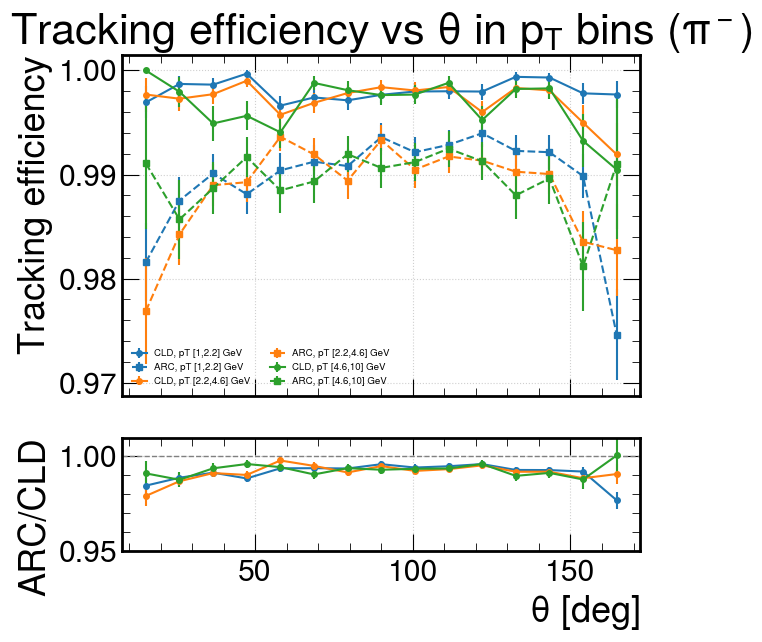

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': 'Tracking efficiency vs $\\theta$ in $p_T$ bins ($\\pi^-$)'}, ylabel='Tracking efficiency'>,
  <Axes: xlabel='$\\theta$ [deg]', ylabel='ARC/CLD'>))

In [18]:
# %%
p_bin_indices = [3, 4, 5]  # choose
labels = [f"pT∈[{PT_BINS[i]:.2g},{PT_BINS[i+1]:.2g}] GeV" for i in p_bin_indices]

curves_cld = [eff_cld["eff_p_theta"][i, :] for i in p_bin_indices]
curves_arc = [eff_arc["eff_p_theta"][i, :] for i in p_bin_indices]
errs_cld   = [eff_cld["err_p_theta"][i, :] for i in p_bin_indices]
errs_arc   = [eff_arc["err_p_theta"][i, :] for i in p_bin_indices]

den_cld = [eff_cld["den_p_theta"][i, :] for i in p_bin_indices]
den_arc = [eff_arc["den_p_theta"][i, :] for i in p_bin_indices]

MIN_ENTRIES = 50
good_masks = [(den_cld[k] >= MIN_ENTRIES) & (den_arc[k] >= MIN_ENTRIES) for k in range(len(p_bin_indices))]

plot_multicurve_with_ratio(
    th_centers,
    curves_cld, curves_arc,
    labels=labels,
    curvesAerr=errs_cld, curvesBerr=errs_arc,
    labelA="CLD", labelB="ARC",
    xlabel=r"$\theta$ [deg]",
    ylabel="Tracking efficiency",
    title=r"Tracking efficiency vs $\theta$ in $p_T$ bins ($\pi^-$)",
    ratio_ylim=(0.95, 1.01),
    mask_good=good_masks,
    # savepath=f"{PLOT_DIR}/trk_eff_theta_multi_pt.png",
)


In [8]:
# %%
P_BINS_RES = np.logspace(0, np.log10(15), 8)   # 1..15 GeV (example)
TH_BINS_RES = np.linspace(20, 160, 16)

res_d0_cld = compute_track_resolution_p_theta(
    CLD_DIR, n_files=N_FILES, idx=IDX,
    p_bins=P_BINS_RES,
    theta_bins=TH_BINS_RES,
    observable="d0",
    min_entries=50,
    pt_min=PT_MIN,
    primary_r_max=PRIMARY_R_MAX,
    primary_z_max=PRIMARY_Z_MAX,
    pdg_filter=PDG_PI,
)

res_d0_arc = compute_track_resolution_p_theta(
    ARC_DIR, n_files=N_FILES, idx=IDX,
    p_bins=P_BINS_RES,
    theta_bins=TH_BINS_RES,
    observable="d0",
    min_entries=50,
    pt_min=PT_MIN,
    primary_r_max=PRIMARY_R_MAX,
    primary_z_max=PRIMARY_Z_MAX,
    pdg_filter=PDG_PI,
)

res_pt_cld = compute_track_resolution_p_theta(
    CLD_DIR, n_files=N_FILES, idx=IDX,
    p_bins=P_BINS_RES,
    theta_bins=TH_BINS_RES,
    observable="pt",
    min_entries=50,
    pt_min=PT_MIN,
    primary_r_max=PRIMARY_R_MAX,
    primary_z_max=PRIMARY_Z_MAX,
    pdg_filter=PDG_PI,
)

res_pt_arc = compute_track_resolution_p_theta(
    ARC_DIR, n_files=N_FILES, idx=IDX,
    p_bins=P_BINS_RES,
    theta_bins=TH_BINS_RES,
    observable="pt",
    min_entries=50,
    pt_min=PT_MIN,
    primary_r_max=PRIMARY_R_MAX,
    primary_z_max=PRIMARY_Z_MAX,
    pdg_filter=PDG_PI,
)


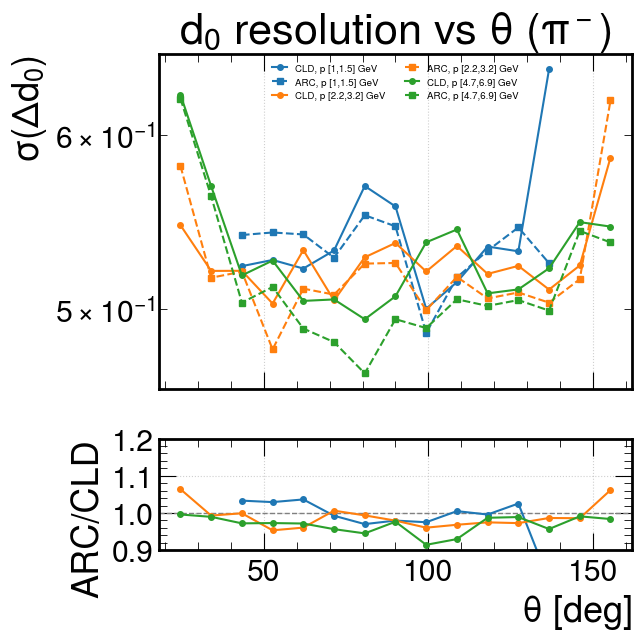

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': '$d_0$ resolution vs $\\theta$ ($\\pi^-$)'}, ylabel='$\\sigma(\\Delta d_0)$'>,
  <Axes: xlabel='$\\theta$ [deg]', ylabel='ARC/CLD'>))

In [9]:
# %%
th_edges = res_d0_cld["theta_bins"]
th_cent = 0.5*(th_edges[:-1] + th_edges[1:])
p_edges = res_d0_cld["p_bins"]

p_bin_indices = [0, 2, 4]
labels = [f"p∈[{p_edges[i]:.2g},{p_edges[i+1]:.2g}] GeV" for i in p_bin_indices]

MIN_ENTRIES = 50
curves_cld = [res_d0_cld["sigma"][i, :] for i in p_bin_indices]
curves_arc = [res_d0_arc["sigma"][i, :] for i in p_bin_indices]
nent_cld   = [res_d0_cld["n_entries"][i, :] for i in p_bin_indices]
nent_arc   = [res_d0_arc["n_entries"][i, :] for i in p_bin_indices]
good_masks = [(nent_cld[k] >= MIN_ENTRIES) & (nent_arc[k] >= MIN_ENTRIES) for k in range(len(p_bin_indices))]

# use fit errors if present, otherwise None -> ratio error propagation still works
err_cld = [res_d0_cld.get("sigma_err", None)[i, :] if "sigma_err" in res_d0_cld else None for i in p_bin_indices]
err_arc = [res_d0_arc.get("sigma_err", None)[i, :] if "sigma_err" in res_d0_arc else None for i in p_bin_indices]

plot_multicurve_with_ratio(
    th_cent,
    curves_cld, curves_arc,
    labels=labels,
    curvesAerr=err_cld, curvesBerr=err_arc,
    labelA="CLD", labelB="ARC",
    xlabel=r"$\theta$ [deg]",
    ylabel=res_d0_cld["ylabel"],
    title=r"$d_0$ resolution vs $\theta$ ($\pi^-$)",
    yscale="log",
    ratio_ylim=(0.9, 1.2),
    mask_good=good_masks,
    # savepath=f"{PLOT_DIR}/trk_d0_res_theta_multi_p.png",
)


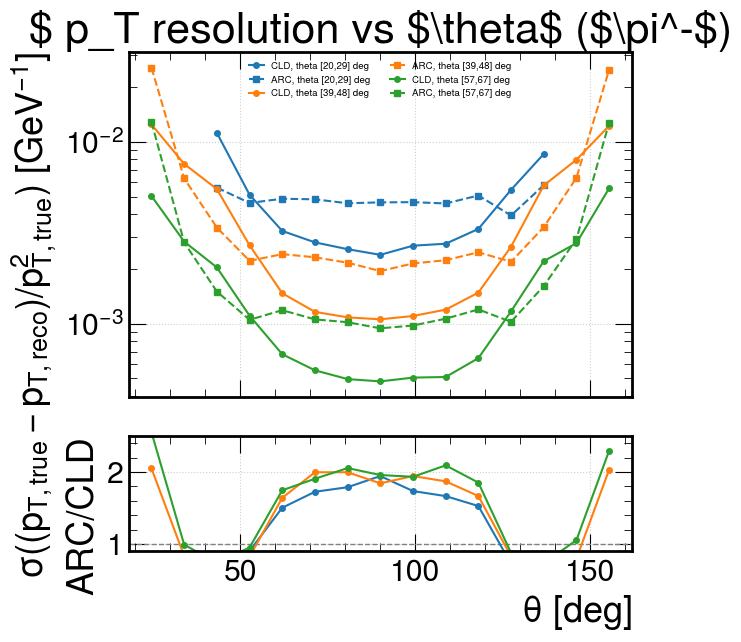

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': '$ p_T resolution vs $\\theta$ ($\\pi^-$)'}, ylabel='$\\sigma((p_{T,true}-p_{T,reco})/p_{T,true}^2)$ [GeV$^{-1}$]'>,
  <Axes: xlabel='$\\theta$ [deg]', ylabel='ARC/CLD'>))

In [10]:
# %%
th_edges = res_pt_cld["theta_bins"]
th_cent = 0.5*(th_edges[:-1] + th_edges[1:])
p_edges = res_pt_cld["p_bins"]

thetabin_indices = [0, 2, 4]
labels = [f"theta∈[{th_edges[i]:.2g},{th_edges[i+1]:.2g}] deg" for i in thetabin_indices]

MIN_ENTRIES = 50
curves_cld = [res_pt_cld["sigma"][i, :] for i in thetabin_indices]
curves_arc = [res_pt_arc["sigma"][i, :] for i in thetabin_indices]
nent_cld   = [res_pt_cld["n_entries"][i, :] for i in thetabin_indices]
nent_arc   = [res_pt_arc["n_entries"][i, :] for i in thetabin_indices]
good_masks = [(nent_cld[k] >= MIN_ENTRIES) & (nent_arc[k] >= MIN_ENTRIES) for k in range(len(thetabin_indices))]

# use fit errors if present, otherwise None -> ratio error propagation still works
err_cld = [res_pt_cld.get("sigma_err", None)[i, :] if "sigma_err" in res_pt_cld else None for i in thetabin_indices]
err_arc = [res_pt_arc.get("sigma_err", None)[i, :] if "sigma_err" in res_pt_arc else None for i in thetabin_indices]

plot_multicurve_with_ratio(
    th_cent,
    curves_cld, curves_arc,
    labels=labels,
    curvesAerr=err_cld, curvesBerr=err_arc,
    labelA="CLD", labelB="ARC",
    xlabel=r"$\theta$ [deg]",
    ylabel=res_pt_cld["ylabel"],
    title=r"$ p_T resolution vs $\theta$ ($\pi^-$)",
    yscale="log",
    ratio_ylim=(0.9, 2.5),
    mask_good=good_masks,
    # savepath=f"{PLOT_DIR}/trk_pt_res_theta_multi_p.png",
)


In [11]:
# %%
res_E_cld = compute_event_energy_binned(
    CLD_DIR, n_files=N_FILES, idx=IDX,
    bin_width=2.0,
    allowed_subdets=SUBDETS_ECAL_HCAL,
    exclude_neutrinos=True,
    exclude_muons_in_true=False,
    E_true_min_for_autobin=75.0,
)

res_E_arc = compute_event_energy_binned(
    ARC_DIR, n_files=N_FILES, idx=IDX,
    bin_width=2.0,
    allowed_subdets=SUBDETS_ECAL_HCAL,
    exclude_neutrinos=True,
    exclude_muons_in_true=False,
    E_true_bins=res_E_cld["E_true_bins"],  # same bins!
)


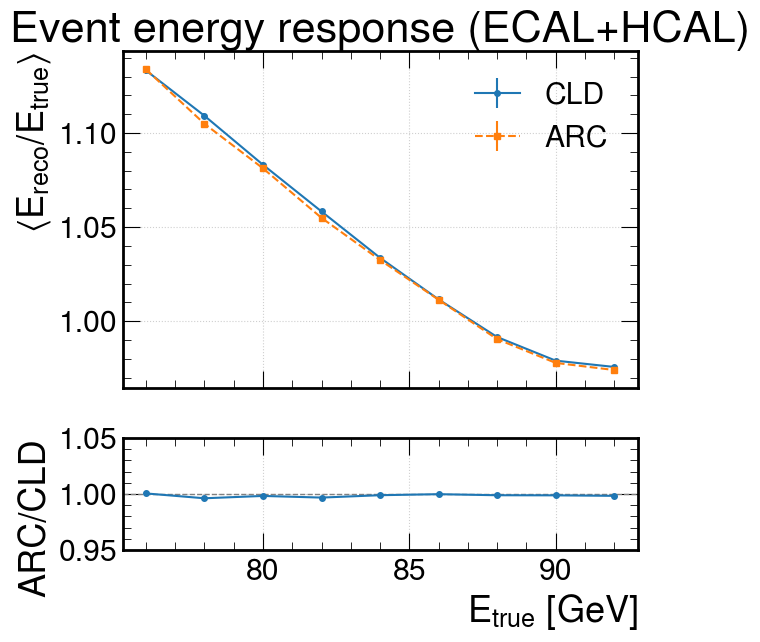

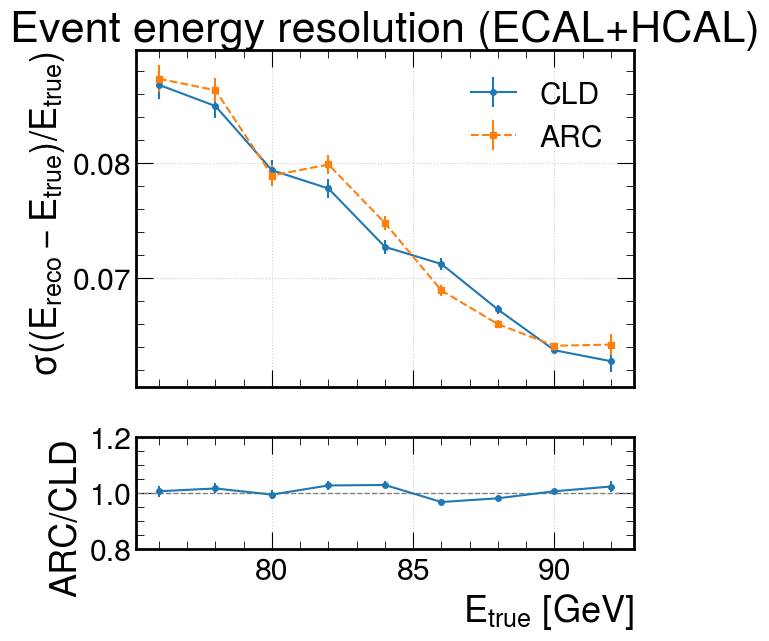

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': 'Event energy resolution (ECAL+HCAL)'}, ylabel='$\\sigma((E_{reco}-E_{true})/E_{true})$'>,
  <Axes: xlabel='$E_{true}$ [GeV]', ylabel='ARC/CLD'>))

In [12]:
# %%
E = res_E_cld["E_true_centers"]

plot_compare_with_ratio(
    E,
    res_E_cld["mean_ratio"], res_E_arc["mean_ratio"],
    res_E_cld["mean_ratio_err"], res_E_arc["mean_ratio_err"],
    xlabel=r"$E_{true}$ [GeV]",
    ylabel=r"$\langle E_{reco}/E_{true}\rangle$",
    title="Event energy response (ECAL+HCAL)",
    ratio_ylim=(0.95, 1.05),
    # savepath=f"{PLOT_DIR}/event_response.png",
)

plot_compare_with_ratio(
    E,
    res_E_cld["sigma"], res_E_arc["sigma"],
    res_E_cld.get("sigma_err"), res_E_arc.get("sigma_err"),
    xlabel=r"$E_{true}$ [GeV]",
    ylabel=r"$\sigma((E_{reco}-E_{true})/E_{true})$",
    title="Event energy resolution (ECAL+HCAL)",
    ratio_ylim=(0.8, 1.2),
    # savepath=f"{PLOT_DIR}/event_resolution.png",
)


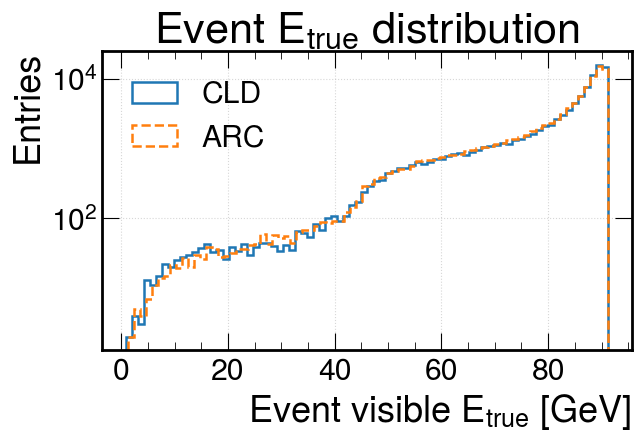

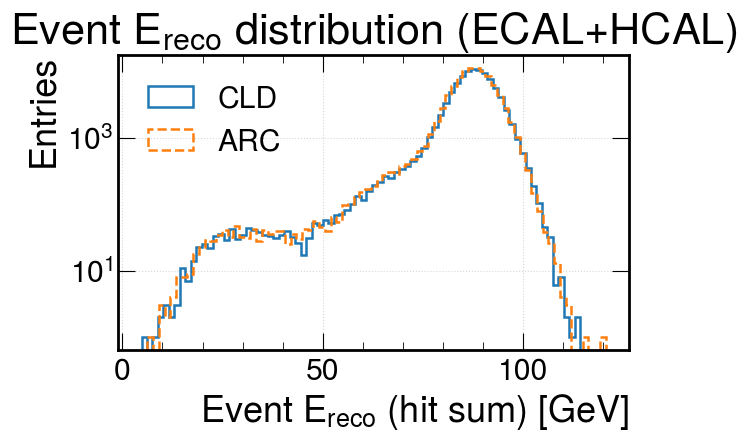

(<Figure size 700x500 with 1 Axes>,
 <Axes: title={'center': 'Event $E_{reco}$ distribution (ECAL+HCAL)'}, xlabel='Event $E_{reco}$ (hit sum) [GeV]', ylabel='Entries'>)

In [13]:
# %%
Etrue_cld = res_E_cld["E_true_events"]
Ereco_cld = res_E_cld["E_reco_events"]
Etrue_arc = res_E_arc["E_true_events"]
Ereco_arc = res_E_arc["E_reco_events"]

# E_true distribution
plot_step_hist_compare(
    Etrue_cld, Etrue_arc,
    bins=80,
    density=False,
    xlabel="Event visible $E_{true}$ [GeV]",
    title="Event $E_{true}$ distribution",
    logy=True,
)

# E_reco distribution
plot_step_hist_compare(
    Ereco_cld, Ereco_arc,
    bins=80,
    density=False,
    xlabel="Event $E_{reco}$ (hit sum) [GeV]",
    title="Event $E_{reco}$ distribution (ECAL+HCAL)",
    logy=True,
)


In [14]:
# %%
PDG_GAMMA = (22,)
res_g_cld = compute_particle_energy_binned(
    CLD_DIR, n_files=500, idx=IDX,
    pdg_filter=PDG_GAMMA,
    allowed_subdets=SUBDETS_ECAL_HCAL,
    bin_width=1.0,
    E_true_max_for_autobin=10.0,
)

res_g_arc = compute_particle_energy_binned(
    ARC_DIR, n_files=500, idx=IDX,
    pdg_filter=PDG_GAMMA,
    allowed_subdets=SUBDETS_ECAL_HCAL,
    bin_width=1.0,
    E_true_bins=res_g_cld["E_true_bins"],
)


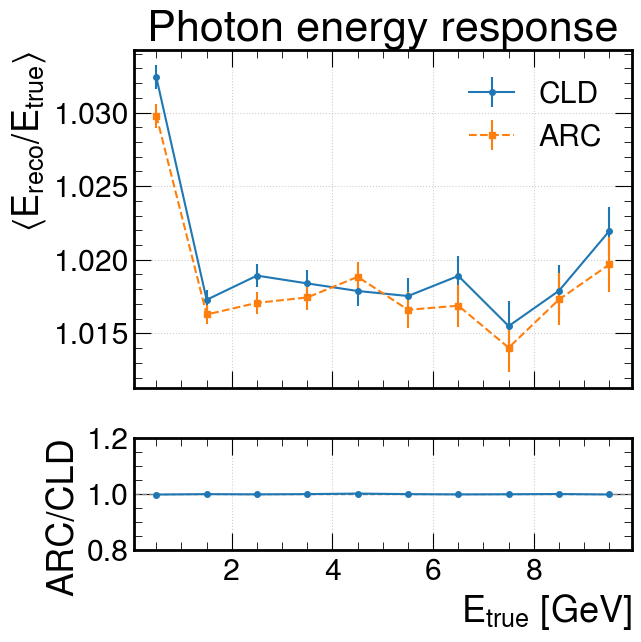

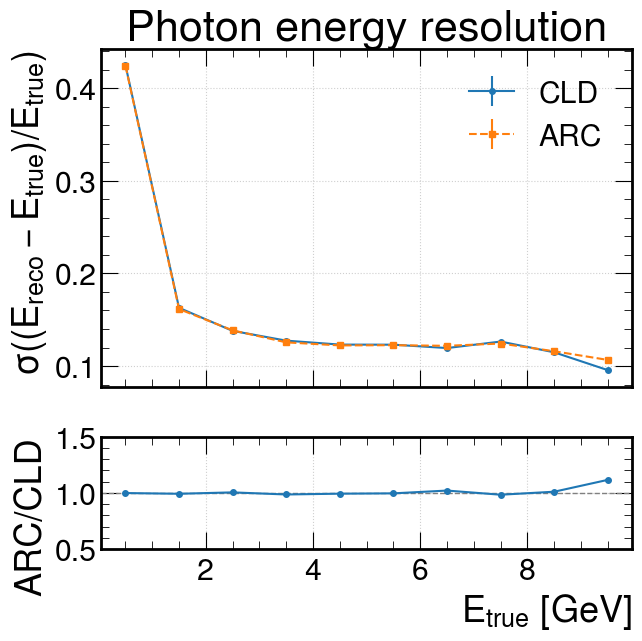

(<Figure size 700x700 with 2 Axes>,
 (<Axes: title={'center': 'Photon energy resolution'}, ylabel='$\\sigma((E_{reco}-E_{true})/E_{true})$'>,
  <Axes: xlabel='$E_{true}$ [GeV]', ylabel='ARC/CLD'>))

In [15]:
# %%
E = res_g_cld["E_true_centers"]

plot_compare_with_ratio(
    E,
    res_g_cld["mean_ratio"], res_g_arc["mean_ratio"],
    res_g_cld["mean_ratio_err"], res_g_arc["mean_ratio_err"],
    xlabel=r"$E_{true}$ [GeV]",
    ylabel=r"$\langle E_{reco}/E_{true}\rangle$",
    title="Photon energy response",
    ratio_ylim=(0.8, 1.2),
)

plot_compare_with_ratio(
    E,
    res_g_cld["sigma"], res_g_arc["sigma"],
    res_g_cld.get("sigma_err"), res_g_arc.get("sigma_err"),
    xlabel=r"$E_{true}$ [GeV]",
    ylabel=r"$\sigma((E_{reco}-E_{true})/E_{true})$",
    title="Photon energy resolution",
    ratio_ylim=(0.5, 1.5),
)


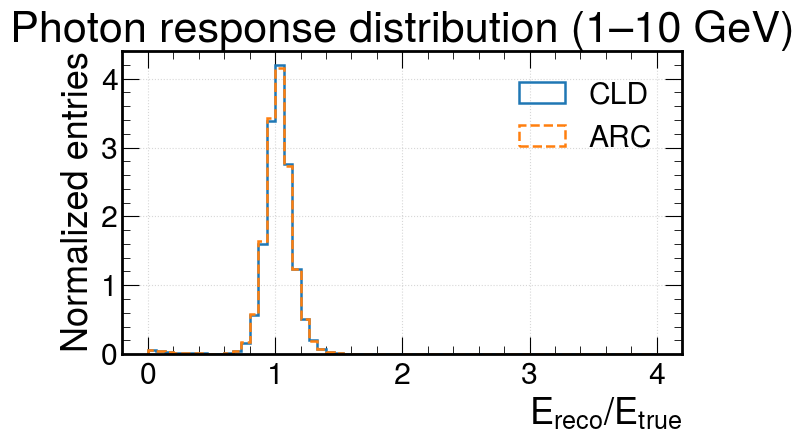

(<Figure size 700x500 with 1 Axes>,
 <Axes: title={'center': 'Photon response distribution (1–10 GeV)'}, xlabel='$E_{reco}/E_{true}$', ylabel='Normalized entries'>)

In [16]:
# %%
ratio_cld = collect_particle_ratio(
    CLD_DIR, n_files=500, idx=IDX,
    pdg_filter=PDG_GAMMA,
    allowed_subdets=SUBDETS_ECAL_HCAL,
    E_true_min=1.0,
    E_true_max=10.0,
)

ratio_arc = collect_particle_ratio(
    ARC_DIR, n_files=500, idx=IDX,
    pdg_filter=PDG_GAMMA,
    allowed_subdets=SUBDETS_ECAL_HCAL,
    E_true_min=1.0,
    E_true_max=10.0,
)

plot_step_hist_compare(
    ratio_cld, ratio_arc,
    bins=60,
    x_range=(0, 4),
    xlabel=r"$E_{reco}/E_{true}$",
    title=r"Photon response distribution (1–10 GeV)",
    logy=False,
)
